In [1]:
import pymongo
from pymongo import MongoClient
import datetime
import dateutil.parser
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
from scipy.misc import imread
from StringIO import StringIO
import math
import pytz
import helpers
# Since I moved most of the functions into their own file I haven't cleaned up the imports section. 
# There is probably unused imports here, but I'd imagine that it's not too much of a problem.

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)

# Get the data we need

To do this analysis, we need to know about the stickers, base stations and detections.

Stickers and base stations are static data, they live in google spreadsheets.

Detections is from the MongoDB database.

---

# Fixed locations

## Stickers
The stickers are the locating items in the space. They are stuck to the ceiling at roughly 2m intervals.

![](ladder300.gif)

They have a QR code on them, so they can be scaned with a phone. That gives us a time stamp and a location.

In future we should be able to get orientation and position in field of view because QR codes have a top.

In [3]:
stickerLocations = helpers.getDFfromCSVURL("https://docs.google.com/spreadsheets/d/1sijQZR2iFLo2FS_3r5gbsuAkaglRz557LWjdLxnPkpE/pub?gid=0&single=true&output=csv")
stickerLocations = stickerLocations.drop(["raw","z"], 1) # this is just because we aren't on multiple floors
stickerLocations.head(3)

,stickerID,x,y
0,1,63852.09440,-13561.617780
1,2,62985.85359,-11830.460440
2,3,62985.85359,-9830.460444


## Base Station (Agent) Locations

We use the term agent and base station interchangably at the moment. In the future we will probably use agent to mean a simulated occupant, so expect to see base station used more.

TODO: put in a base image

These are the Raspberry Pi computers that recieve the beacon packets.

In [4]:
baseStationData = helpers.getDFfromCSVURL("https://docs.google.com/spreadsheets/d/167pxh_NRq5e9sQV9Zb8Z-Q-kdN7Zy9FCzCp47eVXTuE/pub?gid=1446311565&single=true&output=csv")

#only keep the columns we care about
baseStationData = baseStationData.ix[:,0:5]
baseStationData = baseStationData.drop(["location"], 1)
baseStationData = baseStationData[baseStationData.agentId > 0] #not really sure how this works, maybe failure is falsy?
baseStationData.head(3)

,agentId,agentName,x,y
0,00000000e5bd0ae9,Ace,2953.206017,14427.458860
1,000000006c1a3b5a,Alfa,3323.405966,9086.502512
2,0000000020294bbd,Beer,3313.076869,2665.631392


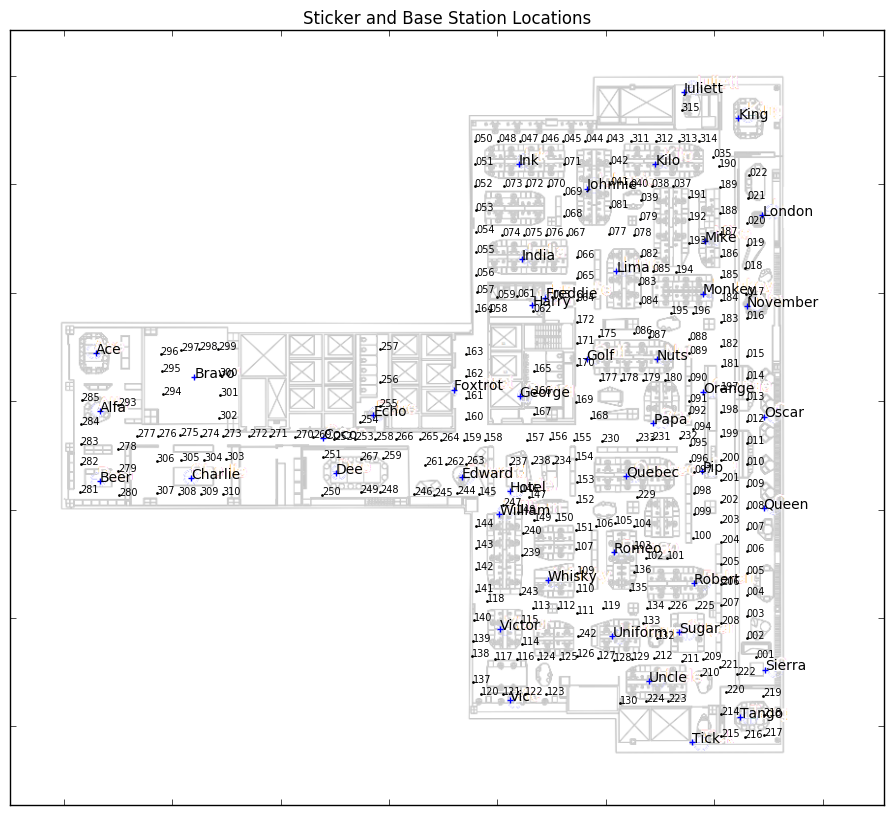

In [14]:
fig, ax = plt.subplots()

plt.title("Sticker and Base Station Locations")

# put the image on the graph as an underlay
img = imread("map.png")
ax.imshow(img, zorder=0, extent=[-1300, 72000, -24000, 41000])
#                                [left,  right, bottom, top  ]

# put the baseStations on the map
for index, row in baseStationData.iterrows():
    ax.text(row.x, row.y, row.agentName, fontsize=10)
ax.scatter(baseStationData.x, baseStationData.y, marker='+')

# Hide the axis numbers because they don't tell us much
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())

# the sticker labels
for index, row in stickerLocations.iterrows():
    ax.text(row.x, row.y, "{0:03d}".format(int(row.stickerID)), fontsize=7)

# sticker dots
ax.scatter(stickerLocations.x, stickerLocations.y, s=1, c="y")

plt.show()


# variable data

## Known Locations

These are generated by me walking around wearing my badge. I scan each sticker as I pass under it. Because the stickers are so close, it's hard for me to take an ambiguous route between them.

The data sets here are test sets. 

TODO: replace these test sets with a series of 5 minute journeys in an array of URLs.

In [5]:
trainingWalkURLs = [
 {"minor":304, "url":"https://docs.google.com/spreadsheets/d/1v20slmW6nz8GnA3u8cbWBYpTuT1UwaLHFSm8AYNNr8E/pub?gid=649191784&single=true&output=csv"},
 {"minor":304, "url":"https://docs.google.com/spreadsheets/d/10QiLgS-oBha4mwwJlzrZb-8BZHb3MPJ7Q3FIrPuTpUA/pub?gid=1669457584&single=true&output=csv"},
 {"minor":304, "url":"https://docs.google.com/spreadsheets/d/1bU-juDRDXl0mVWGCsPvTppaOf7td51R2cP1P6kxjAk4/pub?gid=1291732418&single=true&output=csv"},
 {"minor":304, "url":"https://docs.google.com/spreadsheets/d/12YyeEIds7RSKfF1NVLqy3x8F_hidV3lhNwfsJ8UuBRE/pub?gid=2131252797&single=true&output=csv"},
 {"minor": 39, "url":"https://docs.google.com/spreadsheets/d/e/2PACX-1vT1t1ijtzdVCscBslU6u_VS73ta4Db8bC-MG4unQmA7tBLaKPmqfOdyOav9nSb9S_zDD1jjixkUJL5f/pub?gid=1983825461&single=true&output=csv"}
]

## Get the data and format it ready for use

Get all the data from the spreadsheets.

Give known positions time and coordinates

To make things easier to process later I've joined the coords to the sticker detections

`sydTime` is needed because my phone records the sticker detection times in Sydney local time, but everything else is in UTC. It's not used again unless it's needed for debugging. If datlight saving changes, uncomment and check if it works properly. (I hate timezones!)

In [6]:
trainingWalks = helpers.getTrainingWalkData(trainingWalkURLs, stickerLocations)

0: 2016-11-02 00:28:58+00:00 TO 2016-11-02 00:46:47+00:00 (0 days 00:17:49) 213 rows
1: 2016-11-06 02:20:09+00:00 TO 2016-11-06 02:22:17+00:00 (0 days 00:02:08) 28 rows
2: 2016-11-12 04:31:04+00:00 TO 2016-11-12 04:51:12+00:00 (0 days 00:20:08) 224 rows
3: 2016-11-09 05:13:43+00:00 TO 2016-11-09 05:20:47+00:00 (0 days 00:07:04) 74 rows
4: 2016-11-23 23:06:34+00:00 TO 2016-11-24 00:09:46+00:00 (0 days 01:03:12) 157 rows


In [7]:
t=trainingWalks[4]
t.head()

,stickerID,x,y,time,minor
156,200,60641.64269,4604.746814,2016-11-23 23:06:34+00:00,39
155,204,60641.64269,-3008.669150,2016-11-23 23:07:01+00:00,39
154,205,60641.64269,-4998.802198,2016-11-23 23:07:07+00:00,39
153,206,60618.50161,-6826.947673,2016-11-23 23:07:11+00:00,39
152,207,60618.50161,-8793.939640,2016-11-23 23:07:16+00:00,39


# Get detections associated with each sticker scan

In [8]:
allLiveSets = []
for i, trainingSet in enumerate(trainingWalks[3:]):
    liveSet = trainingSet

    # t=liveSet[:2].apply(nSecondWindows, axis=1) ## can't for the life of me make this work. Maybe post SO question eventually?
    detections = []
    for index, row in liveSet.iterrows():
        dets = helpers.nSecondWindows(row, baseStationData, chatty=False)
        if type(dets) == pd.core.frame.DataFrame:
            detections.append( {"frame":dets,   "detCount":len(dets)})
        else:
            detections.append( {"frame":"duff", "detCount":0})

    liveSet["detections"] = [d["frame"]    for d in detections] 
    liveSet["detCount"]   = [d["detCount"] for d in detections]
    
    allLiveSets.append(liveSet)

In [9]:
allLiveSets[1].iloc[0].detections

,minor,rssi,time,agentName,x,y,rssiAdj
0,39,-97,2016-11-23 23:06:31.875000+00:00,India,42233.09149,23092.235400,3
1,39,-84,2016-11-23 23:06:31.880000+00:00,Sugar,56755.95339,-11320.449410,16
2,39,-66,2016-11-23 23:06:32.835000+00:00,Sugar,56755.95339,-11320.449410,34
3,39,-63,2016-11-23 23:06:33.789000+00:00,Sugar,56755.95339,-11320.449410,37
4,39,-79,2016-11-23 23:06:31.881000+00:00,November,63004.13408,18765.049360,21
5,39,-71,2016-11-23 23:06:32.836000+00:00,November,63004.13408,18765.049360,29
6,39,-98,2016-11-23 23:06:33.787000+00:00,November,63004.13408,18765.049360,2
7,39,-75,2016-11-23 23:06:35.698000+00:00,November,63004.13408,18765.049360,25
8,39,-72,2016-11-23 23:06:31.881000+00:00,Tick,57979.19466,-21431.930720,28
9,39,-88,2016-11-23 23:06:33.790000+00:00,Tick,57979.19466,-21431.930720,12


# Visualise The Training Walks

In [10]:
for i, liveSet in enumerate(allLiveSets):
    savePlace = 'frames/test1/'
    helpers.clearFolder("/"+savePlace)
    #this takes quite a long time if you have a lot of frames
    startStopwatch = datetime.datetime.now()
    print startStopwatch

    for index, row in liveSet.iterrows():
        if index%10==0:
                print index, datetime.datetime.now() - startStopwatch, "elapsed"
        if type(row.detections) == pd.core.frame.DataFrame:
            makeFrames = True
            if makeFrames:
                helpers.timeSliced(row, savePlace, liveSet, baseStationData, stickerLocations)

    print "That took", datetime.datetime.now() - startStopwatch

    helpers.makeGif(savePlace + "*.png", "SampleWalk{}".format(i))

2016-11-24 12:32:17.812062
saving to: frames/test1/Detections for person 304 around 05:13:43.png
saving to: frames/test1/Detections for person 304 around 05:13:50.png
saving to: frames/test1/Detections for person 304 around 05:13:54.png
70 0:00:02.682967 elapsed
saving to: frames/test1/Detections for person 304 around 05:13:58.png
saving to: frames/test1/Detections for person 304 around 05:14:02.png
saving to: frames/test1/Detections for person 304 around 05:14:06.png
saving to: frames/test1/Detections for person 304 around 05:14:11.png
saving to: frames/test1/Detections for person 304 around 05:14:15.png
saving to: frames/test1/Detections for person 304 around 05:14:19.png
saving to: frames/test1/Detections for person 304 around 05:14:24.png
saving to: frames/test1/Detections for person 304 around 05:14:28.png
saving to: frames/test1/Detections for person 304 around 05:14:42.png
saving to: frames/test1/Detections for person 304 around 05:14:49.png
60 0:00:09.970803 elapsed
saving to: 

![](SampleWalk0.gif)

![](SampleWalk1.gif)

![](SampleWalk2.gif)

![](SampleWalk3.gif)

# Training data for tensor flow

Tensor flow will map between an array and a value, this section transforms the data to be in that simple format

In [11]:
def detectionsToTrainingArray(detections):
    # This takes the average detection strength for each base station in a given window.
    # In future it might want to weight that by the number of detections, or take the median or something.
    # but for now, mean seems like a good place to start 
    groups = detections.groupby("agentName", as_index=False)
    g = groups.aggregate(np.mean)
    g = g.drop(["minor","x","y","rssiAdj"], 1)
    g = g.merge(allBases, on="agentName", how='outer')
    g = g.fillna(value=0)
    g = g.sort_values(by="agentName")
    g = g.rssi.tolist()
    return g

In [12]:
#all basestation names
allBases=pd.Series(baseStationData.agentName.unique()).to_frame("agentName")

# for each row, group the detections by base station, average them, then merge them into a long DF
# then fill all the gaps with zero and get just a list of rssi values.
trainingData = []
for thisSet in allLiveSets: 
    for index, row in thisSet.iterrows():
        if type(row.detections) == pd.core.frame.DataFrame:
            trainingData.append({"stickerID":        row.stickerID, 
                                 "detectionVector" : detectionsToTrainingArray(row.detections) })
trainingDF = pd.DataFrame.from_dict(trainingData)
trainingDF.head()

,detectionVector,stickerID
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",73
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",52
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",51
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",50
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",48
